# Explore here

In [ ]:
# Importación
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pickle import dump

# Importación de bibliotecas
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.metrics import accuracy_score

# Importación de alertas
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

# Cargar datos
ruta_datos = '/workspace/random-forest/data/raw/diabetes.csv'
diabetes = pd.read_csv(ruta_datos)

# Mostrar las primeras filas y la estructura del conjunto de datos
print("Primeras filas del conjunto de datos:")
print(diabetes.head())

print("\nEstructura del conjunto de datos:")
print(diabetes.info())



Primeras filas del conjunto de datos:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Estructura del conjunto de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies

# Exploratory Data Analysis (EDA)

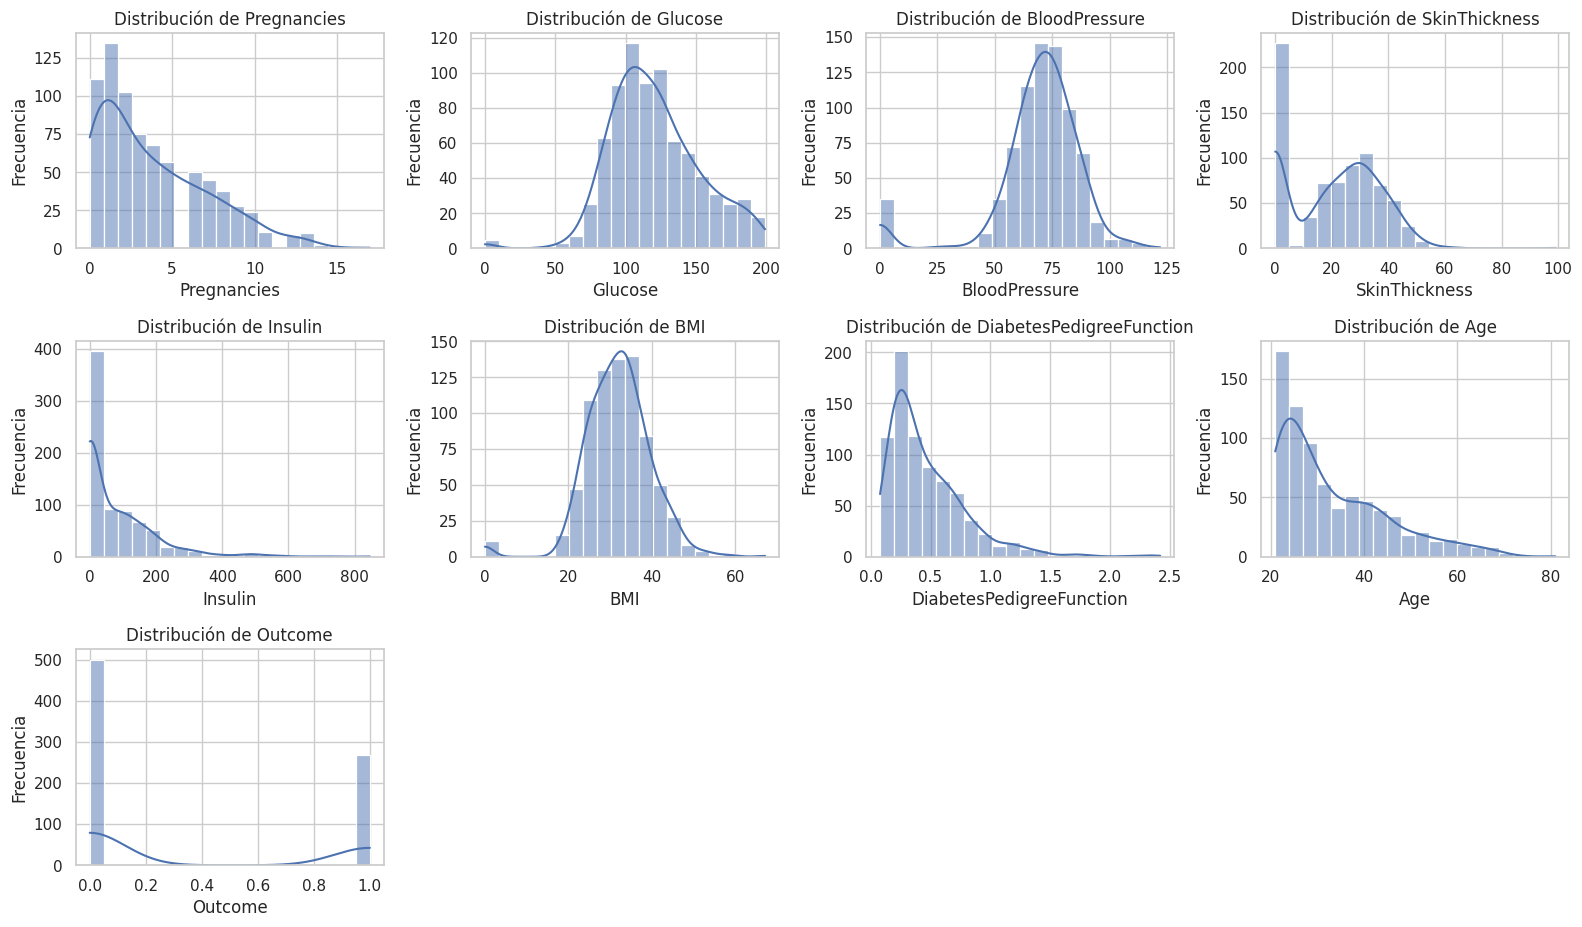

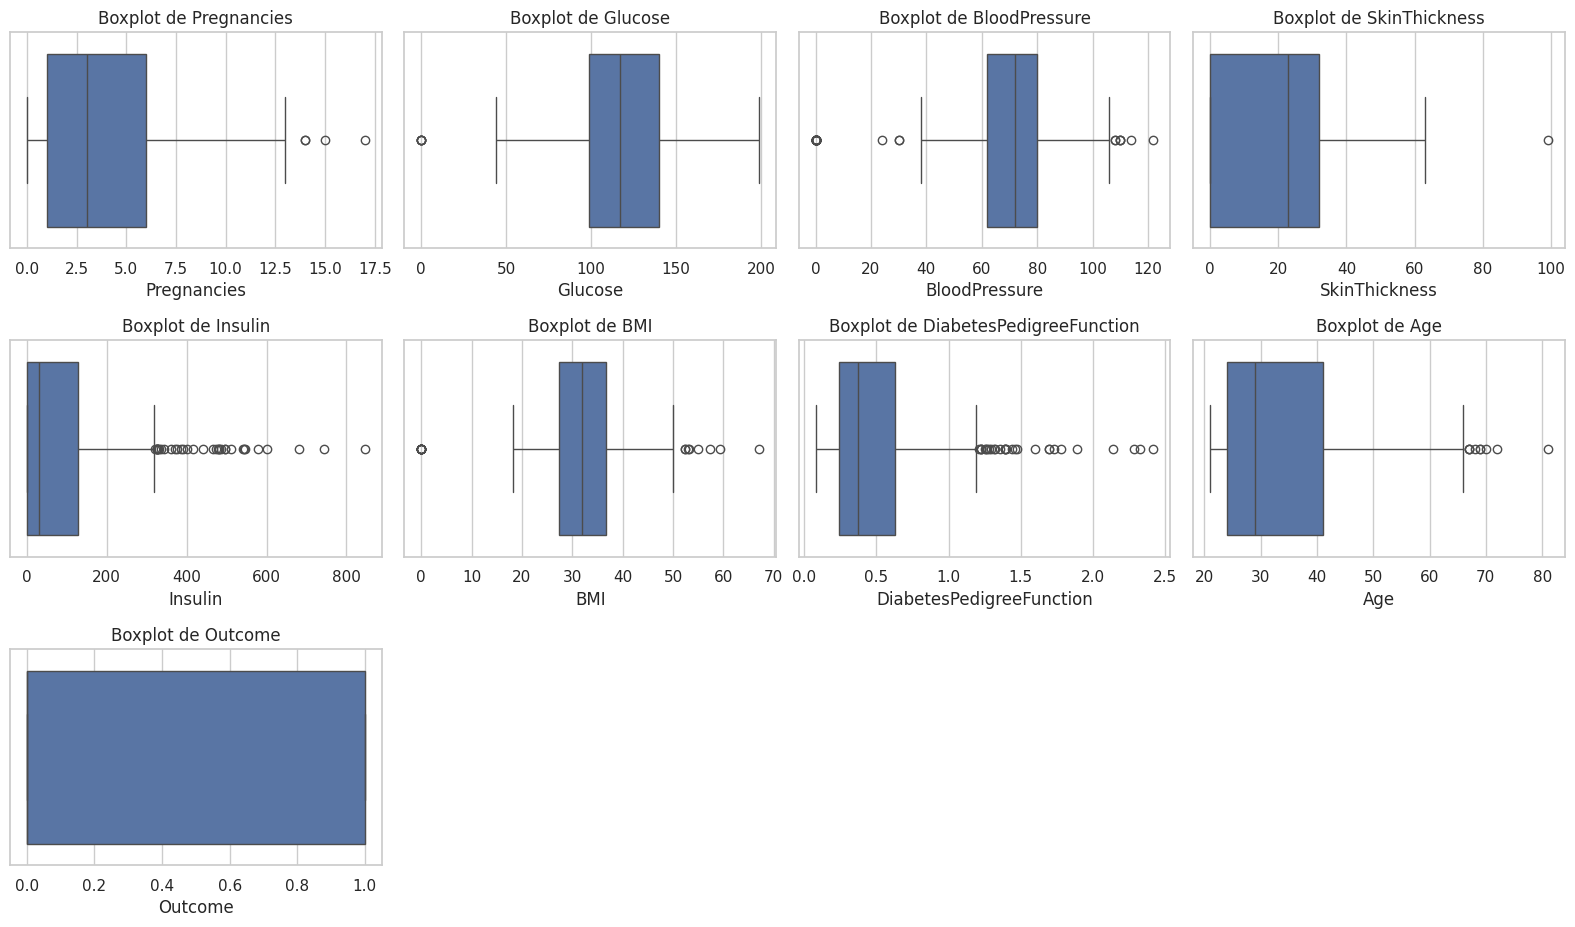

In [15]:
# Análisis univariado: Distribución de las variables numéricas
# Extraemos las variables numéricas del dataframe
numerical_columns = diabetes.select_dtypes(include=['int64', 'float64']).columns

# Definir tamaño de la figura
plt.figure(figsize=(16, 12))

# Crear histogramas y boxplots para cada variable numérica
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, i)  # Subgráficos de 4x4
    sns.histplot(diabetes[col], kde=True, bins=20)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Boxplots para ver la presencia de outliers
plt.figure(figsize=(16, 12))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, i)  # Subgráficos de 4x4
    sns.boxplot(x=diabetes[col])
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()



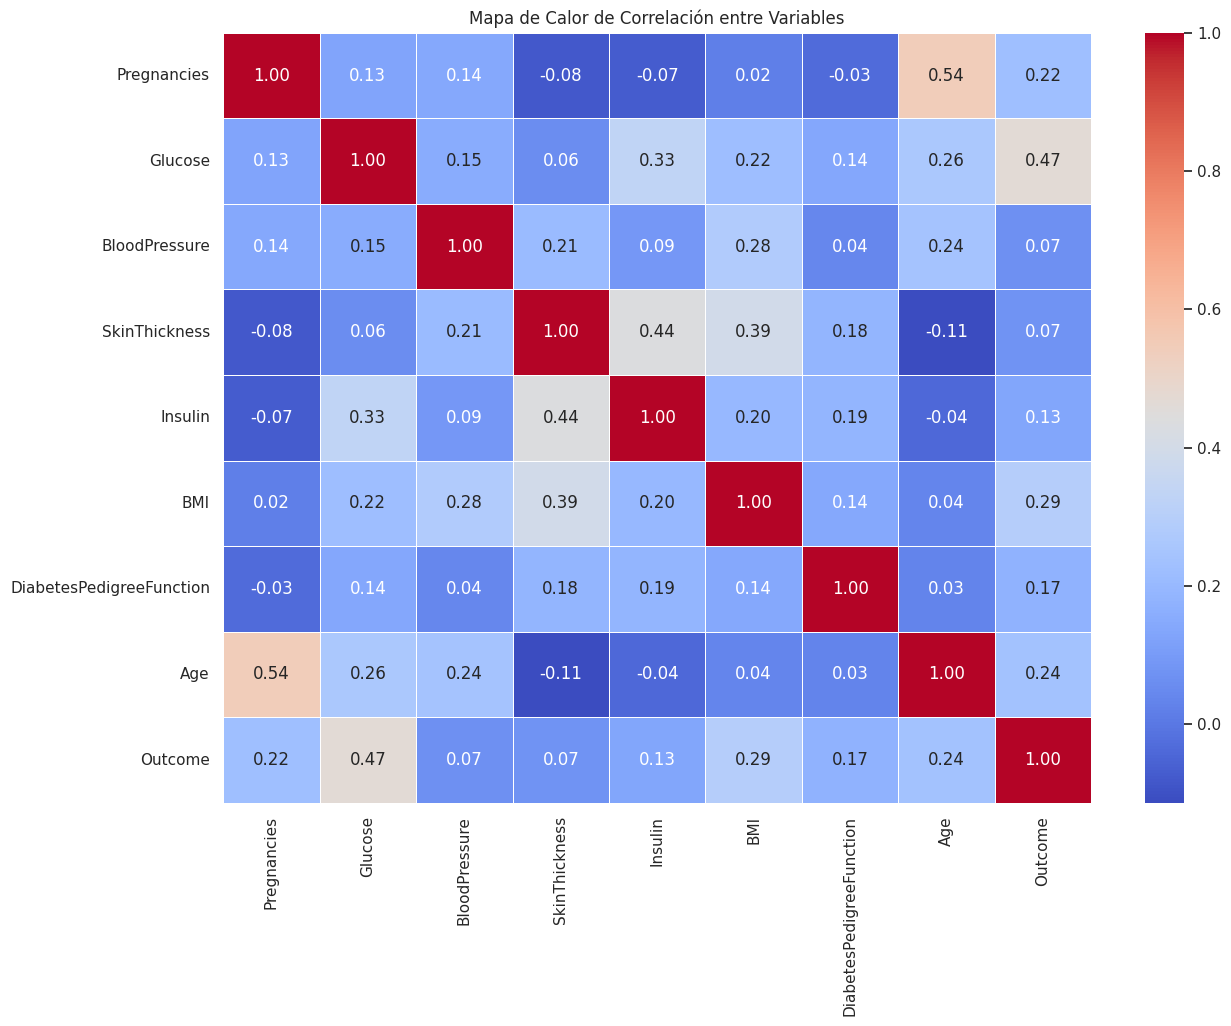

In [16]:
# Parte 2
# Correlación entre las variables numéricas
correlation_matrix = diabetes.corr()

# Crear un mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)
plt.title('Mapa de Calor de Correlación entre Variables')
plt.show()



# Preparación del modelo

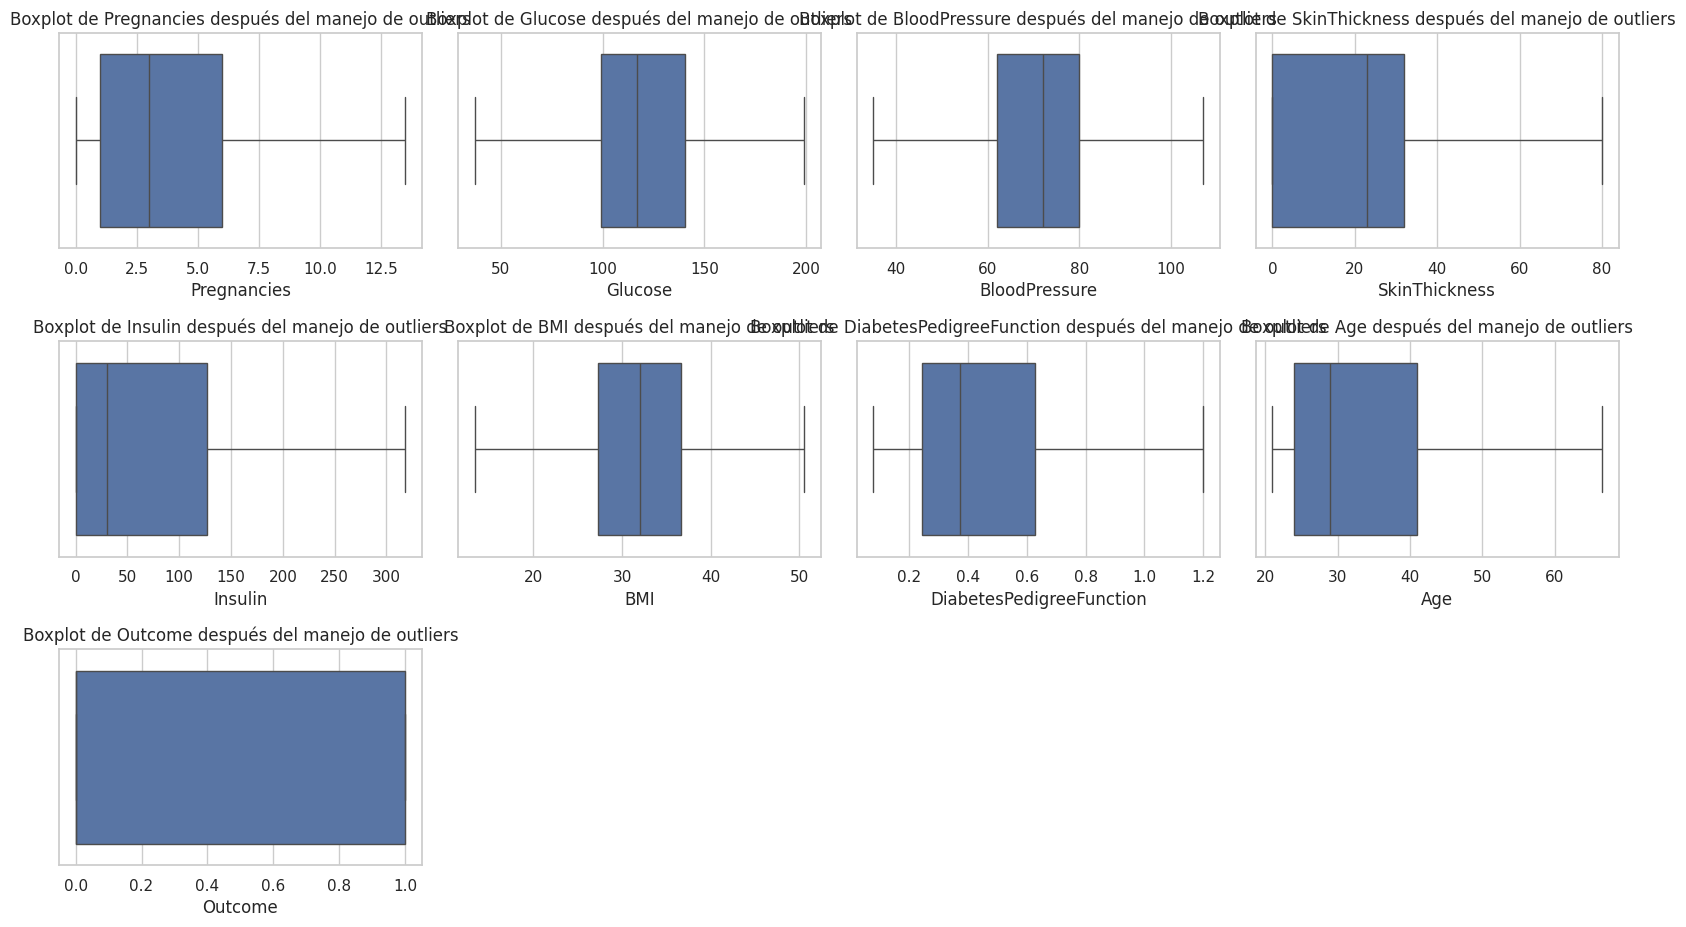

Scaler guardado en: /workspace/random-forest/data/processed/scaler_standard.pkl


In [27]:
# Función para reemplazar los outliers por el límite inferior o superior
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Reemplazamos los valores por los límites
    df[column] = df[column].apply(lambda x: lower_limit if x < lower_limit else x)
    df[column] = df[column].apply(lambda x: upper_limit if x > upper_limit else x)

    return df

# Aplicamos la función a todas las columnas numéricas
numerical_columns = diabetes.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_columns:
    diabetes = handle_outliers(diabetes, col)

# Verificamos que los outliers han sido manejados
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, i)  # Subgráficos de 4x4
    sns.boxplot(x=diabetes[col])
    plt.title(f'Boxplot de {col} después del manejo de outliers')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

import os
from joblib import dump

# Verificar si la carpeta de destino existe, si no, crearla
output_dir = '/workspace/random-forest/data/processed'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Guardar el scaler usando joblib
scaler_path = os.path.join(output_dir, 'scaler_standard.pkl')
dump(scaler, scaler_path)

# Mostrar la ubicación en la que se guardó el archivo
print(f"Scaler guardado en: {scaler_path}")

# Dividir los datos en entrenamiento y prueba
X = diabetes.drop(columns='Outcome')
y = diabetes['Outcome']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Guardar los conjuntos de entrenamiento y prueba
X_train.to_csv('/workspace/random-forest/data/processed/X_train.csv', index=False)
X_test.to_csv('/workspace/random-forest/data/processed/X_test.csv', index=False)
y_train.to_csv('/workspace/random-forest/data/processed/y_train.csv', index=False)
y_test.to_csv('/workspace/random-forest/data/processed/y_test.csv', index=False)

# Aplicar el escalado a los datos de entrenamiento y prueba
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Guardar los conjuntos de datos escalados
X_train_scaled.to_csv('/workspace/random-forest/data/processed/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('/workspace/random-forest/data/processed/X_test_scaled.csv', index=False)



# Modelo de random forest: ENTRENAMIENTO

In [28]:
# Cargar los conjuntos de entrenamiento y prueba
X_train = pd.read_csv('/workspace/random-forest/data/processed/X_train_scaled.csv')
X_test = pd.read_csv('/workspace/random-forest/data/processed/X_test_scaled.csv')
y_train = pd.read_csv('/workspace/random-forest/data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('/workspace/random-forest/data/processed/y_test.csv').values.ravel()

# Verificar que los datos se hayan cargado correctamente
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')



X_train shape: (614, 8)
X_test shape: (154, 8)
y_train shape: (614,)
y_test shape: (154,)


# Construcción y optimización del modelo

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Construir el modelo Random Forest
rf_model = RandomForestClassifier(random_state=123)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Evaluar el modelo utilizando la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy del modelo Random Forest: {accuracy:.4f}')


Accuracy del modelo Random Forest: 0.7597


In [30]:
# Definir el espacio de búsqueda para los hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo Random Forest
rf_model = RandomForestClassifier(random_state=123)

# Ejecutar GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Ver los mejores hiperparámetros
print(f'Best parameters found: {grid_search.best_params_}')

# Evaluar el modelo optimizado
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)

# Evaluar precisión del modelo optimizado
optimized_accuracy = accuracy_score(y_test, y_pred_best)
print(f'Accuracy del modelo Random Forest optimizado: {optimized_accuracy:.4f}')


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.9s


In [31]:
# Guardar el modelo optimizado
dump(best_rf_model, '/workspace/random-forest/data/processed/random_forest_model.pkl')
print("Modelo Random Forest optimizado guardado.")


Modelo Random Forest optimizado guardado.


                    Feature  Importance
1                   Glucose    0.269572
5                       BMI    0.173411
7                       Age    0.140043
6  DiabetesPedigreeFunction    0.127187
2             BloodPressure    0.082109
4                   Insulin    0.074338
3             SkinThickness    0.068826
0               Pregnancies    0.064515


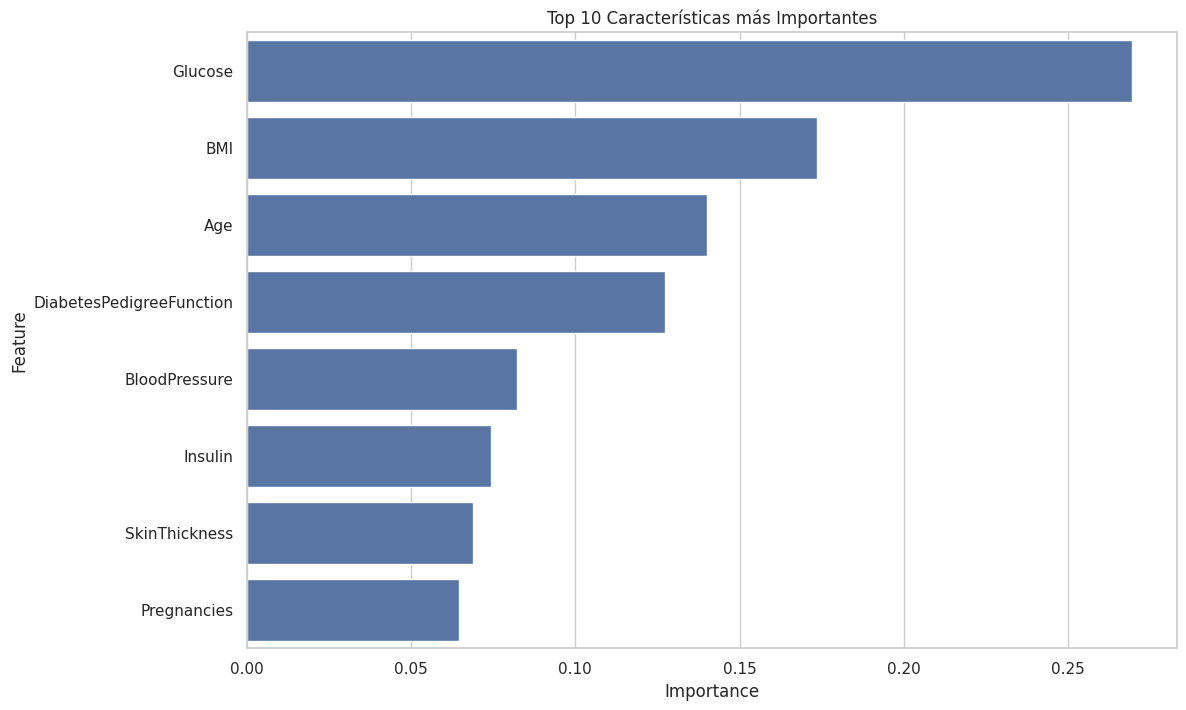

In [32]:
# Visualizar la importancia de las características
feature_importances = best_rf_model.feature_importances_

# Crear un DataFrame para las características y sus importancias
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Ordenar por la importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
print(importance_df.head(10))

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Características más Importantes')
plt.show()
